In [1]:
!pip install plotly

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import plotly.offline as pyo
pyo.init_notebook_mode()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from cv2 import imread, resize
import datetime
from plotly.subplots import make_subplots
from sklearn import preprocessing
import random
import tensorflow
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from mpl_toolkits.mplot3d import Axes3D
import h5py
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU memory growth set to True")

GPU memory growth set to True


In [4]:
pip install --upgrade keras

  Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.7.0+nv22.2 requires keras<2.8,>=2.7.0rc0, but you have keras 2.15.0 which is incompatible.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import keras
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In [6]:
import random as rn

np.random.seed(30)

rn.seed(30)

from keras import backend as k

tf.random.set_seed(30)

In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Accessing the files

train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [9]:
batch_size = 32


In [10]:
len(train_doc), len(val_doc)

(663, 100)

In [11]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

In [12]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    axes[0].set_title('Training and Validation Loss')


    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    axes[1].set_title('Training and Validation Categorical Accuracy')

Generator

In [13]:
def resize_image(image, y, z, channels):
    if image is None:
        print("Error: Unable to read image. Check file path/integrity.")
        return None

    if (y, z) == (120, 120):
        if image.shape[1] == 360:
            image = cv2.resize(image, (y, z), interpolation=cv2.INTER_LINEAR)
        elif image.shape[1] == 160:
            image = image[:, 20:140]
        return image
    elif (y, z) == (160, 160):
        if image.shape[1] == 360:
            image = cv2.resize(image, (y, z), interpolation=cv2.INTER_LINEAR)
        elif image.shape[1] == 160:
            image = np.concatenate([np.zeros((20, 160, channels)), image[:, :], np.zeros((20, 160, channels))], axis=0)
        return image

In [14]:
def generator(source_path, folder_list, batch_size):
    print('Source path = ', source_path, '; batch size =', batch_size)
    # create a list of image numbers you want to use for a particular video
    img_idx = list(range(30))[::3]
    while True:
        t = np.random.permutation(folder_list)
        # calculate the number of batches
        num_batches = len(folder_list) // batch_size

        x = len(img_idx)
        y, z = (120, 120)
        for batch in range(num_batches):  # we iterate over the number of batches
            # x is the number of images you use for each video, (y,z) is the final size of the input images, and 3 is the number of channels RGB
            batch_data = np.zeros((batch_size, x, y, z, 3))
            # batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size, 5))
            for folder in range(batch_size):  # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+t[folder + (batch*batch_size)].split(';')[0])  # read all the images in the folder
                for idx, item in enumerate(img_idx):  # Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    # videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos)
                    # crop the images and resize them. Note that the images are of 2 different shapes
                    # and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_image(image)
                    assert image.shape == (y, z, 3), print(f'{image.shape} || {(y, z, 3)}')

                    # normalize and feed in the image
                    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0]
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1]
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2]

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels  # you yield the batch_data and the batch_labels, remember what does yield do

        # Handling remaining data points after full batches
        remaining_data_points = len(folder_list) % batch_size
        if remaining_data_points > 0:
            # Initialize arrays for remaining data points
            remaining_batch_data = np.zeros((remaining_data_points, x, y, z, 3))
            remaining_batch_labels = np.zeros((remaining_data_points, 5))

            for folder in range(remaining_data_points):
                # Similar to the code inside the batch generation loop but for the remaining data points
                # Get the current folder index
                current_folder_index = folder + (num_batches * batch_size)
                # Access the corresponding folder from the permuted list
                current_folder = t[current_folder_index]
                # Read all the images in the folder
                imgs = os.listdir(source_path+'/'+current_folder.split(';')[0])

                for idx, item in enumerate(img_idx):
                    # Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+current_folder.strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    # videos have two types of dimensions - either 360x360 or 120x160
                    # crop the images and resize them
                    image = resize_image(image)
                    assert image.shape == (y, z, 3), print(f'{image.shape} || {(y, z, 3)}')

                    # normalize and feed in the image
                    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                    remaining_batch_data[folder, idx, :, :, 0] = image[:, :, 0]
                    remaining_batch_data[folder, idx, :, :, 1] = image[:, :, 1]
                    remaining_batch_data[folder, idx, :, :, 2] = image[:, :, 2]

                remaining_batch_labels[folder, int(current_folder.strip().split(';')[2])] = 1

            yield remaining_batch_data, remaining_batch_labels

# End of the generator function

In [15]:
def generator(source_path, folder_list, batch_size):
    img_idx = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 27, 28, 29]
    channels = 3

    while True:
        t = np.random.permutation(folder_list)

        if len(folder_list) % batch_size == 0:
            num_batches = len(folder_list) // batch_size
        else:
            num_batches = (len(folder_list) // batch_size) + 1

        x = len(img_idx)
        y, z = (120, 120)  # image height, image width

        for batch in range(num_batches):
            num_covered_images = batch * batch_size
            num_images_left = len(folder_list) - num_covered_images
            batch_size = min(num_images_left, batch_size)

            batch_data = np.zeros((batch_size, x, y, z, channels))
            batch_labels = np.zeros((batch_size, 5))

            for folder in range(batch_size):
                imgs = os.listdir(source_path + '/' + t[num_covered_images + folder].split(';')[0])

                for idx, item in enumerate(img_idx):
                    image = imread(source_path + '/' + t[num_covered_images + folder].strip().split(';')[0] + '/' + imgs[item])
                    image = resize_image(image, y, z)
                    assert image.shape == (y, z, 3), print(f'{image.shape} || {(y, z, 3)}')

                    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0]
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1]
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2]

                batch_labels[folder, int(t[num_covered_images + folder].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [16]:
def generator(source_path, folder_list, batch_size, grayscale=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)

    #create a list of image numbers you want to use for a particular video
    img_idx = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 27, 28, 29]
    channels = 1 if grayscale else 3

    while True:

        t = np.random.permutation(folder_list)

        # calculate the number of batches
        if len(folder_list) % batch_size == 0:
            num_batches = len(folder_list) // batch_size
        else:
            num_batches = (len(folder_list) // batch_size) + 1

        x = len(img_idx)
        # y, z = (120, 120) #image height, image width
        y, z = (160, 160) #image height, image width

        for batch in range(num_batches): # we iterate over the number of batches
            num_covered_images = batch*batch_size # images already batched
            num_images_left = len(folder_list) - num_covered_images # images left to be batched
            # if images left are less than batch size (partial last batch)
            # then update batch size
            batch_size = num_images_left if (num_images_left < batch_size) else batch_size
            # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros((batch_size,x,y,z,channels))
            # batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[num_covered_images + folder].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[num_covered_images + folder].strip().split(';')[0]+'/'+imgs[item])#.astype(np.float32)

                    #videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos)
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_image(image, y, z, channels)
                    assert image.shape == (y, z, 3), print(f'{image.shape} || {(y, z, 3)}') # keep channels 3, not yet converted to grayscale

                    #normalise and feed in the image
                    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

                    if grayscale:
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        batch_data[folder,idx,:,:,0] = image[:,:]
                    else:
                        batch_data[folder,idx,:,:,0] = image[:,:,0]
                        batch_data[folder,idx,:,:,1] = image[:,:,1]
                        batch_data[folder,idx,:,:,2] = image[:,:,2]

                batch_labels[folder, int(t[num_covered_images + folder].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


In [17]:
one_batch = next(generator(train_path, train_doc, batch_size, grayscale=False))
one_batch[0].shape, one_batch[1].shape

Source path =  /home/datasets/Project_data/train ; batch size = 32


((32, 18, 160, 160, 3), (32, 5))

In [18]:
num_covered_images = 90
folder = 3
item = 10
y, z = (120, 120)
t = np.random.permutation(train_doc)
imgs = os.listdir(train_path+'/'+ t[num_covered_images + folder].split(';')[0])
image = imread(train_path+'/'+ t[num_covered_images + folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

In [19]:
image.shape

(360, 360, 3)

In [20]:
if image.shape[1] == 360:
     image = resize(image, (y, z), interpolation=cv2.INTER_LINEAR)
elif image.shape[1] == 160:
     image = image[:, 20:140]

In [21]:
image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

In [22]:
image

array([[[0.13492064, 0.13492064, 0.13492064],
        [0.15079366, 0.14285715, 0.14285715],
        [0.1468254 , 0.1388889 , 0.1388889 ],
        ...,
        [0.9920635 , 0.9920635 , 1.        ],
        [0.98412704, 1.        , 1.        ],
        [0.9603175 , 1.        , 0.9801588 ]],

       [[0.12698413, 0.15873016, 0.15476191],
        [0.13492064, 0.15873016, 0.15476191],
        [0.15476191, 0.16269842, 0.16269842],
        ...,
        [0.9920635 , 1.        , 0.98412704],
        [0.98412704, 1.        , 0.98412704],
        [0.9642858 , 1.        , 0.98412704]],

       [[0.49603176, 0.52380955, 0.5119048 ],
        [0.25396827, 0.28174606, 0.26984128],
        [0.10714287, 0.13095239, 0.12698413],
        ...,
        [0.9920635 , 1.        , 0.9761905 ],
        [0.9920635 , 1.        , 0.98412704],
        [0.97222227, 1.        , 0.98412704]],

       ...,

       [[0.06746032, 0.06746032, 0.11507937],
        [0.06746032, 0.07539683, 0.11507937],
        [0.05952381, 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


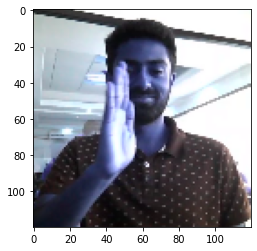

In [23]:
plt.imshow(image)

In [24]:
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [25]:
!pip install tensorflow


  Using cached keras-2.7.0-py2.py3-none-any.whl (1.3 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


MODEL BUILDING

In [26]:
# Lets import some more necessary required libraries
from tensorflow.keras import layers, models
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling3D

MODEL 1 CONV3D

In [27]:
#write your model here

# Your create_model_cnn3d function here with 3d convolution and maxpooling3d and averagepooling3d

def create_model_cnn3d(width=120, height=120, frames=30, channels=3):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, frames, channels))

    x = layers.Conv3D(filters=16, kernel_size=3, strides=1, padding='same', activation="relu")(inputs)
    x = layers.MaxPooling3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=32, kernel_size=3, strides=1, padding='same', activation="relu")(x)
    x = layers.MaxPooling3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, strides=1, padding='same', activation="relu")(x)
    x = layers.MaxPooling3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(units=5, activation="softmax")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model

In [28]:
from __main__ import create_model_cnn3d

# Assuming create_model_cnn3d is defined in the same script or notebook
module_name = create_model_cnn3d.__module__
print(f"The function create_model_cnn3d is defined in the module: {module_name}")


The function create_model_cnn3d is defined in the module: __main__


In [29]:
# Building our first model

grayscale = False
frames = one_batch[0].shape[1]
channels = 1 if grayscale else 3


model = create_model_cnn3d(width=120, height=120, frames=30, channels=3)

2024-02-06 14:46:08.359365: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [30]:
#compiling model 1

learning_rate = 5e-5
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [31]:
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 30, 3)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 120, 120, 30, 16)  1312      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 60, 60, 15, 16)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 15, 16)   64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 60, 60, 15, 32)    13856     
                                                             

In [32]:
train_generator = generator(train_path, train_doc, batch_size, grayscale=grayscale)
val_generator = generator(val_path, val_doc, batch_size, grayscale=grayscale)

In [33]:
print(model)

In [34]:
model_name = '../models/model_init_2024-01-3104_18_41.915369/' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.makedirs(model_name)


filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
callbacks_list = [checkpoint, early_stop, LR]

In [35]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [36]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                               callbacks=callbacks_list, validation_data=val_generator,
                               validation_steps=validation_steps, class_weight=None,
                               initial_epoch=0)  # Adjust the batch size as needed

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20


2024-02-06 14:46:12.095939: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.5971 - categorical_accuracy: 0.2217Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to ../models/model_init_2024-01-3104_18_41.915369/2024-02-0614_46_02.612644/model-00001-1.59710-0.22172-1.60340-0.23000.keras
21/21 [==============================] - 43s 2s/step - loss: 1.5971 - categorical_accuracy: 0.2217 - val_loss: 1.6034 - val_categorical_accuracy: 0.2300 - lr: 5.0000e-05
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5304 - categorical_accuracy: 0.3395
Epoch 00002: saving model to ../models/model_init_2024-01-3104_18_41.915369/2024-02-0614_46_02.612644/model-00002-1.53041-0.33954-1.58039-0.43750.keras
21/21 [==============================] - 23s 1s/step - loss: 1.5304 - categorical_accuracy: 0.3395 - val_loss: 1.5804 - val_categorical_accuracy: 0.4375 - lr: 5.0000e-05
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.4859 - categorical_a

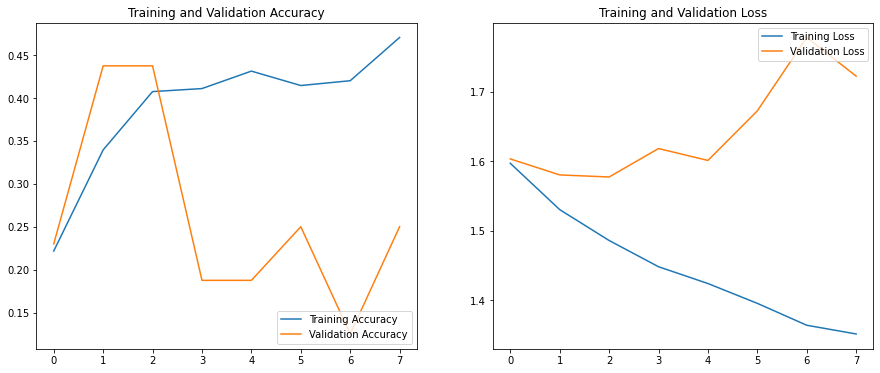

In [37]:
#Lets plot the graph to check accuracy

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Cleary we can see that model is not in good fitting, so lets try another model

# MODEL 2 - CONV3D with Dropout

In [38]:
#write your 2nd model

def create_model_cnn3d(width=120, height=120, depth=30, channels=3):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, channels))

    x = layers.Conv3D(filters=32, kernel_size=3, strides=1, padding='same', activation="relu")(inputs)
    x = layers.Conv3D(filters=32, kernel_size=3, strides=1, padding='same', activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    # x = layers.Conv3D(filters=64, kernel_size=3, strides=1, padding='same', activation="relu")(x)
    # x = layers.MaxPool3D(pool_size=2)(x)
    # x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, strides=1, padding='same', activation="relu")(x)
    x = layers.Conv3D(filters=64, kernel_size=3, strides=1, padding='same', activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, strides=1, padding='same', activation="relu")(x)
    x = layers.Conv3D(filters=128, kernel_size=3, strides=1, padding='same', activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(units=5, activation="softmax")(x)

    # Define the model.
    model2 = keras.Model(inputs, outputs, name="3dcnn")
    return model2

In [39]:
# Building our second model

grayscale = False
frames = one_batch[0].shape[1]
channels = 1 if grayscale else 3


model2 = create_model_cnn3d(width=120, height=120, channels=3)

In [40]:
#compiling model 2

learning_rate = 5e-5
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [41]:
model2.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 30, 3)  0         
                             ]                                   
                                                                 
 conv3d_3 (Conv3D)           (None, 120, 120, 30, 32)  2624      
                                                                 
 conv3d_4 (Conv3D)           (None, 120, 120, 30, 32)  27680     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 60, 60, 15, 32)   0         
 3D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 60, 60, 15, 32)   128       
 hNormalization)                                                 
                                                             

In [42]:
train_generator2 = generator(train_path, train_doc, batch_size, grayscale=grayscale)
val_generator2 = generator(val_path, val_doc, batch_size, grayscale=grayscale)

In [43]:
print(model_name)

../models/model_init_2024-01-3104_18_41.915369/2024-02-0614_46_02.612644/


In [44]:
model_name = '../models/model_init_2024-01-3104_18_41.915369/2024-02-0613_45_49.474980/' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.makedirs(model_name)  # Use os.makedirs for nested directories

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)
# write the ReduceLROnPlateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
# callbacks_list = [checkpoint, LR, early_stop]
callbacks_list = [checkpoint, early_stop]

In [45]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [46]:
# Training our model 2
history2 = model2.fit_generator(train_generator2, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                               callbacks=callbacks_list, validation_data=val_generator2,
                               validation_steps=validation_steps, class_weight=None, workers=1,
                               initial_epoch=0)  # Adjust the batch size as needed

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.4950 - categorical_accuracy: 0.3167Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to ../models/model_init_2024-01-3104_18_41.915369/2024-02-0613_45_49.474980/2024-02-0614_46_02.612644/model-00001-1.49497-0.31674-1.60260-0.25000.h5
21/21 [==============================] - 77s 3s/step - loss: 1.4950 - categorical_accuracy: 0.3167 - val_loss: 1.6026 - val_categorical_accuracy: 0.2500
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.3694 - categorical_accuracy: 0.3934
Epoch 00002: saving model to ../models/model_init_2024-01-3104_18_41.915369/2024-02-0613_45_49.474980/2024-02-0614_46_02.612644/model-00002-1.36939-0.39337-1.61086-0.06250.h5
21/21 [==============================] - 25s 1s/step - loss: 1.3694 - categorical_accuracy: 0.3934 - val_loss: 1.6109 - val_categorical_accuracy: 0.0625


In [47]:
# lets save the output of this model

from keras.models import load_model

model2.save('trained_model2.h5')


In [48]:
# lets check the location of file where it get saved
import os
print(os.getcwd())

/home


In [49]:

loaded_model = load_model('trained_model2.h5')

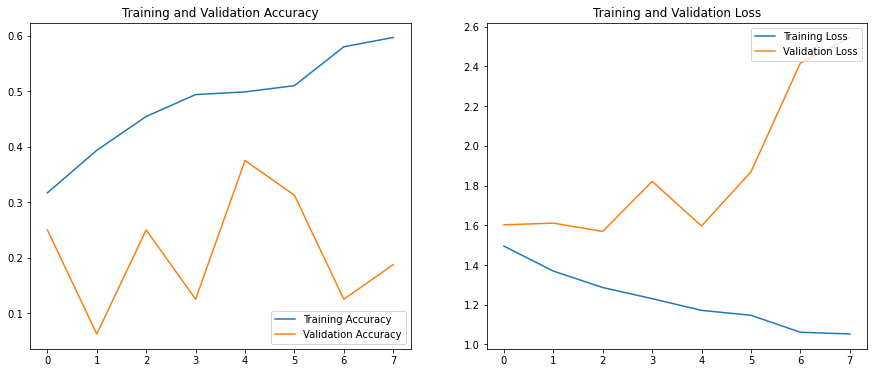

In [50]:
acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(len(history2.history['loss']))

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### above plot shows much better accuracy achieved in both training and validation data as compared to previous one

# MODEL 3 PRETRAINNED TDCNN

In [81]:
len(train_doc), len(val_doc)

(663, 100)

In [84]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3686771377457881957
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15519580160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14770300017752186217
physical_device_desc: "device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2024-02-06 15:25:33.499047: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [85]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

# Load VGG16 base model without specifying input shape
base_model = VGG16(weights='imagenet', include_top=False)

# Display the initial input shape expected by the base model
print("VGG16 Initial Input Shape:", base_model.input_shape[1:])

# Provide the path to an image for testing
img_path = '/home/datasets/Project_data/train/WIN_20180926_18_07_05_Pro_Right_Swipe_new/WIN_20180926_18_07_05_Pro_00009.png'  # Replace with the actual path to your image
img = image.load_img(img_path, target_size=(120, 120))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Get the predicted output, which also updates the input shape of the base model
base_model.predict(img_array)

# Display the updated input shape expected by the base model
print("VGG16 Updated Input Shape:", base_model.input_shape[1:])

VGG16 Initial Input Shape: (None, None, 3)
VGG16 Updated Input Shape: (None, None, 3)


In [86]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras import Input


def create_transfer_model(input_shape=(120, 120, 3), num_classes=5):
    input_tensor = Input(shape=input_shape)

    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

    for layer in base_model.layers:
        layer.trainable = False  # Freeze the pre-trained layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    transfer_model = Model(inputs=input_tensor, outputs=predictions)

    return transfer_model

# Adjust input_shape based on your image size
input_shape = (120, 120, 3)
num_classes = 5
transfer_model = create_transfer_model(input_shape=input_shape, num_classes=num_classes)

# Print the input shape of the transfer model
print("Transfer Model Input Shape:", transfer_model.input_shape[1:])


Transfer Model Input Shape: (120, 120, 3)


In [87]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import load_img, img_to_array

def resize_image(image, target_size):
    return load_img(image, target_size=target_size)

def generator(source_path, folder_list, batch_size, input_shape):
    img_idx = list(range(30))[::3]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size

        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, input_shape[0], input_shape[1], input_shape[2]))
            batch_labels = np.zeros((batch_size, 5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+t[folder + (batch*batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    image_path = source_path+'/'+t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]

                    # Load and resize the image
                    image = resize_image(image_path, target_size=(input_shape[0], input_shape[1]))
                    image = img_to_array(image)

                    # Normalize and feed in the image
                    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                    batch_data[folder, :, :, :] = image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


In [88]:
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    return lr * 0.9  # Adjust the multiplication factor as needed

learning_rate = 1e-4
optimizer = Adam(learning_rate=learning_rate)

transfer_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Use the LearningRateScheduler callback during model training
lr_scheduler = LearningRateScheduler(scheduler)


In [91]:
# Assuming you have one-hot encoded labels
batch_size = 32

train_generator3 = generator(train_path, train_doc, batch_size, input_shape)
val_generator3 = generator(val_path, val_doc, batch_size, input_shape)

# Calculate steps per epoch and validation steps
steps_per_epoch = len(train_path) // batch_size
validation_steps = len(val_path) // batch_size

# Training model
epochs = 50

history3 = transfer_model.fit_generator(
    train_generator3,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator3,
    validation_steps=validation_steps
)


Epoch 1/50
1/1 [==============================] - 1s 824ms/step - loss: 1.4096 - accuracy: 0.5000
Epoch 2/50
1/1 [==============================] - 0s 240ms/step - loss: 1.4153 - accuracy: 0.5625
Epoch 3/50
1/1 [==============================] - 1s 1s/step - loss: 1.4629 - accuracy: 0.4375
Epoch 4/50
1/1 [==============================] - 1s 763ms/step - loss: 1.4360 - accuracy: 0.5625
Epoch 5/50
1/1 [==============================] - 1s 749ms/step - loss: 1.4020 - accuracy: 0.5312
Epoch 6/50
1/1 [==============================] - 1s 967ms/step - loss: 1.4029 - accuracy: 0.4688
Epoch 7/50
1/1 [==============================] - 1s 948ms/step - loss: 1.4028 - accuracy: 0.5000
Epoch 8/50
1/1 [==============================] - 1s 893ms/step - loss: 1.4888 - accuracy: 0.3438
Epoch 9/50
1/1 [==============================] - 1s 959ms/step - loss: 1.4346 - accuracy: 0.4688
Epoch 10/50
1/1 [==============================] - 1s 783ms/step - loss: 1.5050 - accuracy: 0.2812
Epoch 11/50
1/1 [=====

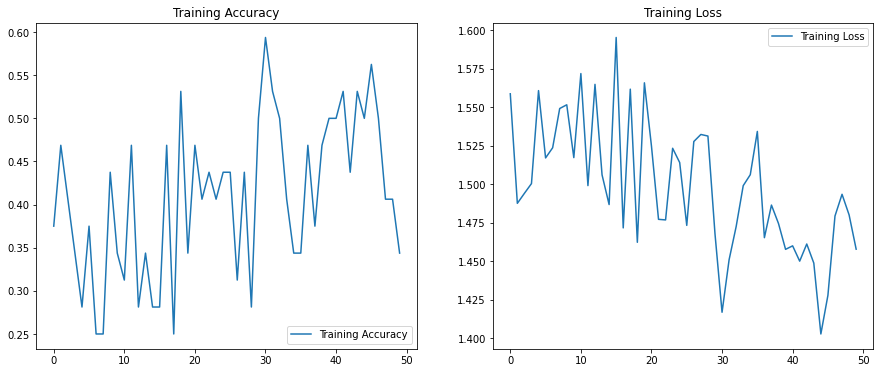

In [92]:
import matplotlib.pyplot as plt

# Assuming `history` contains the training history
acc = history.history['accuracy']

loss = history.history['loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()


#this could also not achieved the desired result, so lets consider the second model which is trained with CNN3D with dropouts is best out of all